In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MARIGOLD as mg
import os
import openpyxl as op

%load_ext autoreload
%autoreload 2

WARNING: Covariance calculation logic still needs some work. What I mean by that is, calc_COV_RC() and calc_COV_TI() both work, but how they're being called in iate_1d_1g() is a little funny.

If you are working with a lot of different geometries and want to change when to use COV and when not to use COV, you should take a look at iate_1d_1g() and CTRL+F 'cov_method'. I'll continue working on this in the meantime to make picking COV calculation method more intuitive.

In [26]:
############################################################################################################################
#                                                                                                                          #
#                                                         INPUTS                                                           #
#                                                                                                                          #
############################################################################################################################
# DATA module
author = 'quan'                 # Determines which dataset you're using
refetch = True                  # Refetch data?

# DATA PROCESSING module
reconstruct_opt = False          # Void reconstruction for COV calculation. May want to implement something similar to 'passkey', if you are interested in only reconstructing for certain L/D or something

############################################################################################################################
# IATE module
z_step = 0.01                   # Axial step size [-] nondimensional, units in L/D ***If you're inputting in [m], convert to diameters

# This part is important for running composite geometries
# The 'endpoints' variable sets IATE function queries (up to how far L/D will the function predict)
# The variable 'modes' dictates what the IATE geometry is
#endpoints = [116, 244]          # IATE function endpoints
#modes = [None, None]

# endpoints       = [180, 250]  
# modes           = ['U-bend Dissipation', 'vd']

#endpoints       = [115.90]  #inlet of U-bend 

# endpoints       = [148]  #U-bend
# modes           = ['U-bend'] #U-bend

endpoints       = [115.90, 147.57,167.4, 240]    #whole test section 
modes           = ['vu', 'U-bend','U-bend Dissipation', 'vd']   #whole test section

# endpoints       = [167.4, 240]    #vu+U-bend
# modes           = ['U-bend Dissipation','vd']   
# endpoints       = [250]  #vd
# modes           = ['vd'] #vd

#endpoints       = [112]  #vd
#modes           = [None] #vd

# endpoints       = [166]    
# modes           = ['U-bend Dissipation']   


# passkey = 'True'                # Logical statement which can restrict which conditions to run (see below for example)
#passkey = ('cond.LoverD > 144')
#passkey = ('cond.jf == 4.00 and cond.jgref == 0.100')
# passkey = ('cond.LoverD > 145')    #vd+u-bend dissi
# passkey = ('cond.LoverD > 100 and cond.LoverD < 148')    #U-bend
# passkey = ('cond.LoverD > 100 and cond.LoverD < 166')    #U-bend+dssipation
# passkey = ('cond.LoverD > 180')  #vd
#passkey = ('cond.LoverD > 20 and cond.LoverD < 120')  #vu
passkey = ('cond.LoverD > 20')
#passkey = ('cond.LoverD > 152')
#passkey = ('cond.jf == 4.00 and cond.jgref == 0.100')

############################################################################################################################
# Plotting module

# Most likely not going to be relevant for general use, so most of this is going to be commented out
# If you intend to compare results against previous MATLAB cases, I pasted the MATLAB results I was interested in, into an Excel sheet:
xlwb = "H:\TRSL-H\IATE\Legacy\Talley_Suite\H\standard_talley.xlsx"

perr = 0.1                      # Error bar percent error (in decimal form; 0.1 = 10%)
xl_compare = False              # When plotting, compare against Excel?
multiplot = True               # When plotting, plot with ai with contributions, void fraction, pressure? If False, will only plot ai


In [8]:
############################################################################################################################
#                                                                                                                          #
#                                                          DATA                                                            #
#                                                                                                                          #
############################################################################################################################
# Extracts data from database, specified by author
# Will want to change the working directory to where you keep your spreadsheets

database = None

if author == 'ryan':
    cwd = os.path.abspath("H:\TRSL-H\IATE\Data\spreadsheets\\25.4mm_ryan")
    dat_to_fetch = 'database_r.dat'

    if refetch:
        mg.extractLocalDataFromDir(cwd, dump_file=dat_to_fetch, sheet_type='ryan_template')

elif author == 'quan':
    cwd = os.path.abspath("C:/Users/quanz/PhD")
    dat_to_fetch = 'U-bend_database.dat'

    if refetch:
        mg.extractLocalDataFromDir(cwd, dump_file=dat_to_fetch, sheet_type='adix_template')

elif author == 'yadav':
    cwd = os.path.abspath("H:\TRSL-H\IATE\Data\spreadsheets\\50.8mm")
    dat_to_fetch = 'database_y.dat'

    if refetch:
        mg.extractLocalDataFromDir(cwd, dump_file=dat_to_fetch, sheet_type='yadav_template')

elif author == 'bettis':
    cwd = os.path.abspath("H:\TRSL-H\IATE\Data\Data_Summary_OneGroup")
    dat_to_fetch = 'database_b.dat'

    if refetch:
        mg.extractLocalDataFromDir(cwd, dump_file=dat_to_fetch, sheet_type='bettis_template')

else:
    database = mg.loadProbeData('./database.dat')

if database == None:
    database = mg.loadProbeData(dat_to_fetch)

Nope. Skipping...


In [27]:
############################################################################################################################
#                                                                                                                          #
#                                                     DATA PROCESSING                                                      #
#                                                                                                                          #
############################################################################################################################
# This module does a few things:
# 1. Unique flow condition finding and sorting, for plotting and other hijinks
# 2. Determine starting L/D
# 3. Void profile reconstruction for all conditions except initial condition

LoverDs = []
designations = []

for cond in database:
    if abs(cond.theta- 90) < 1e-6 and cond.port != 'P4':
      #  cond.mirror(axisym=True)
        cond.mirror(axisym=True, sym90=True, force_remirror=True)
    else:
       cond.mirror(sym90=True)      # to be used later for specifying Port 4

    #if cond.theta == 90:
     #           cond.mirror(axisym=True, sym90=True, force_remirror=True, uniform_rmesh=True)
    #else:
      #          cond.mirror(axisym=True)

    cond:mg.Condition

    if eval(passkey):        

        designations.append([abs(cond.theta), cond.jf, cond.jgref])
        LoverDs.append(cond.LoverD)

designations = np.array(designations)
designations = np.unique(designations,axis=0)

LoverDs = np.array(LoverDs)
LoverDs = np.unique(LoverDs)

########################################################################################################################
# Condition organization

condor = [[0]*len(LoverDs) for _ in range(len(designations))]

for cond in database:
    cond:mg.Condition

    if eval(passkey):

        run_idx = int(np.where((designations == [abs(cond.theta), cond.jf, cond.jgref]).all(axis=1))[0])
        port_idx = int(np.where(LoverDs == cond.LoverD)[0])

        condor[run_idx][port_idx] = cond

sp = np.min(LoverDs)
print(f"\nStarting L/D: {sp}")

########################################################################################################################
# Void profile reconstruction

if reconstruct_opt == True:
    for cond in database:
        cond:mg.Condition

        if eval(passkey):

            if cond.theta == 90:
                cond.mirror(axisym = True)
            else:
                cond.mirror(sym90 = True)

            if cond.LoverD != sp:                
                cond.reconstruct_void(method='talley',avg_method='legacy_old')



Starting L/D: 30.0


WARNING:
There is an assumption in the module below that 90 degree implies axisymmetry
For vertical-downward cases, this may not be the true

In [28]:
for cond in condor:
    print(cond)

[jf=0.7_jgloc=0.33_theta=90_port=P1_adix, jf=0.7_jgloc=0.35_theta=90_port=P2_adix, jf=0.7_jgloc=0.38_theta=90_port=P3_adix, jf=0.7_jgloc=0.38_theta=90_port=P4_adix, jf=0.7_jgloc=0.38_theta=-90_port=P5_adix, jf=0.7_jgloc=0.38_theta=-90_port=P6_adix, jf=0.7_jgloc=0.38_theta=-90_port=P7_adix, jf=0.7_jgloc=0.37_theta=-90_port=P8_adix, jf=0.7_jgloc=0.37_theta=-90_port=P9_adix, jf=0.7_jgloc=0.36_theta=-90_port=P10_adix]
[jf=2.0_jgloc=0.10_theta=90_port=P1_adix, jf=2.0_jgloc=0.11_theta=90_port=P2_adix, jf=2.0_jgloc=0.12_theta=90_port=P3_adix, jf=2.0_jgloc=0.12_theta=90_port=P4_adix, jf=2.0_jgloc=0.12_theta=-90_port=P5_adix, jf=2.0_jgloc=0.12_theta=-90_port=P6_adix, jf=2.0_jgloc=0.12_theta=-90_port=P7_adix, jf=2.0_jgloc=0.12_theta=-90_port=P8_adix, jf=2.0_jgloc=0.11_theta=-90_port=P9_adix, jf=2.0_jgloc=0.11_theta=-90_port=P10_adix]
[jf=2.0_jgloc=0.33_theta=90_port=P1_adix, jf=2.0_jgloc=0.36_theta=90_port=P2_adix, jf=2.0_jgloc=0.39_theta=90_port=P3_adix, jf=2.0_jgloc=0.40_theta=90_port=P4_adix,

jf=0.7_jgloc=0.33_theta=90_port=P1_adix
Geometry is set to: vu
io is set to: None
Geometry is set to: U-bend
io is set to: {'ai': array([402.94106667, 402.92768088, 402.91019913, ..., 275.43640013,
       275.42720235, 275.41801366]), 'alpha': array([0.26694667, 0.30806492, 0.30806759, ..., 0.33239785, 0.33240085,
       0.33240386]), 'Db': array([0.00397804, 0.0045874 , 0.00458764, ..., 0.00724083, 0.00724113,
       0.00724144]), 'jf': 0.7, 'jgloc': array([0.33421698, 0.33422144, 0.33422566, ..., 0.37416208, 0.3741672 ,
       0.37417232]), 'jgatm': 0.482, 'aiti': array([0.        , 0.        , 0.        , ..., 0.20072336, 0.2030603 ,
       0.20540587]), 'airc': array([0.00000000e+00, 1.16578419e-02, 2.71635188e-02, ...,
       1.02691351e+02, 1.02700509e+02, 1.02709667e+02]), 'aiexp': array([0.00000000e+00, 2.29887087e-04, 4.59769603e-04, ...,
       1.72362369e+00, 1.72379962e+00, 1.72397554e+00]), 'aiwe': array([0.00000000e+00, 1.95782786e-03, 4.16379210e-03, ...,
       1.449906

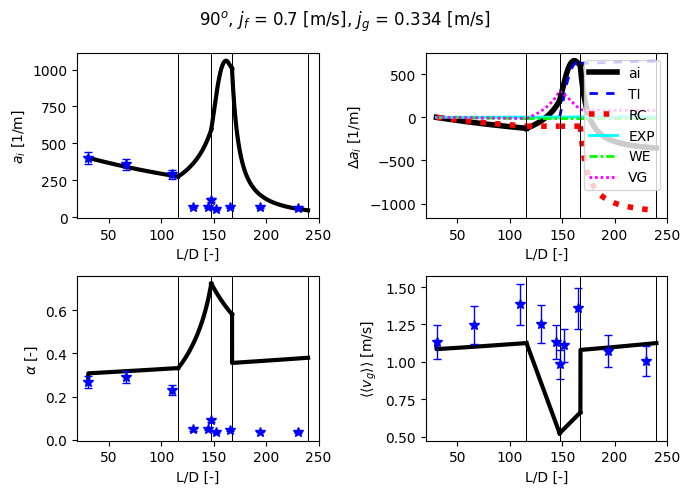

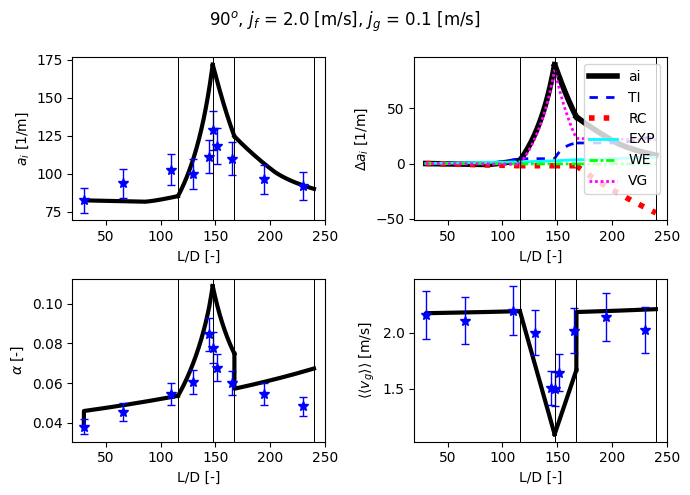

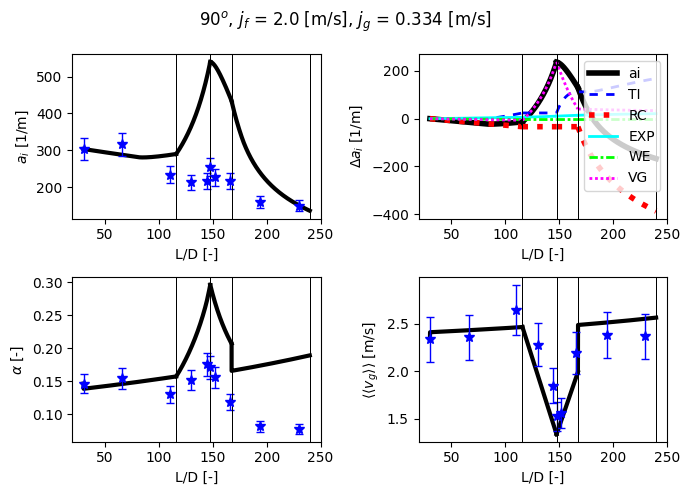

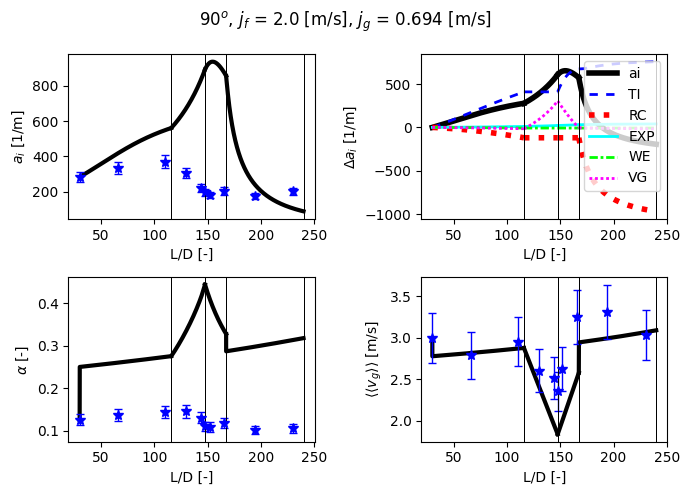

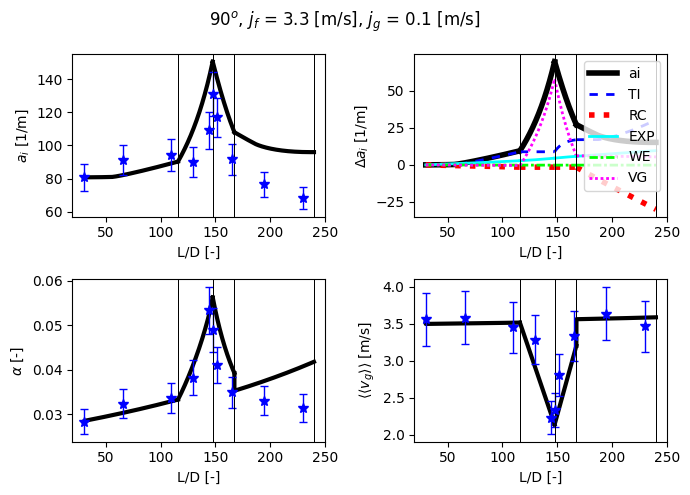

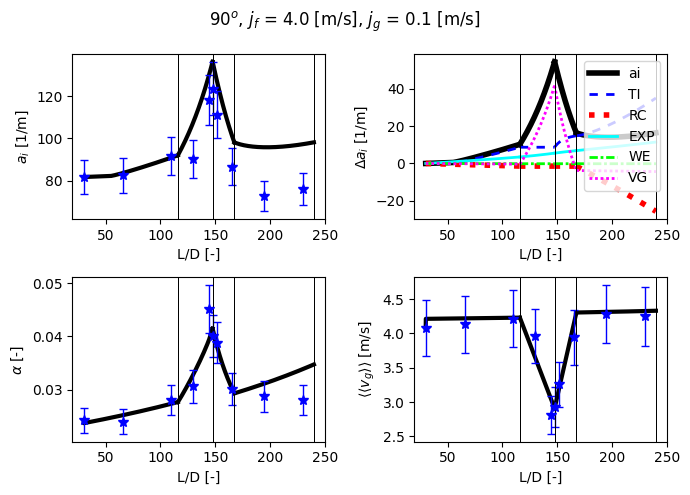

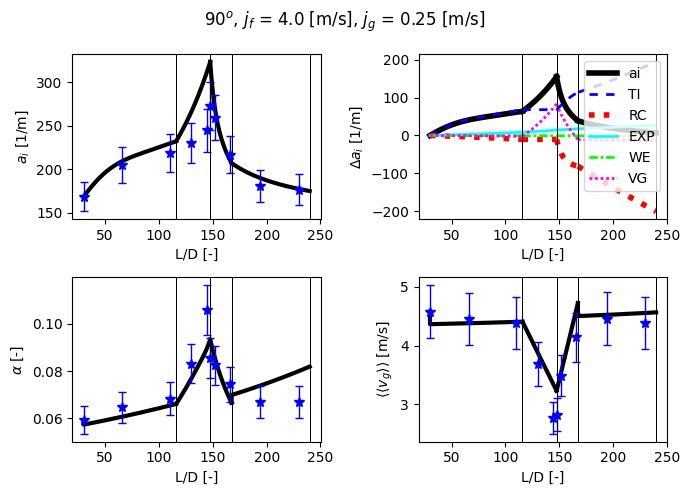

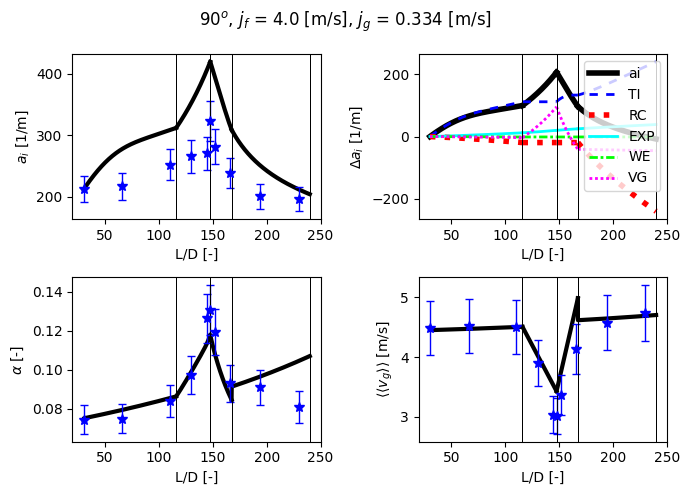

In [29]:
############################################################################################################################
#                                                                                                                          #
#                                                          IATE                                                            #
#                                                                                                                          #
############################################################################################################################
# This module runs the IATE itself
# Iterates through organized conditions. Input 'passkey' can be used if you want to impose any restrictions on which conditions are being run

for i, cond in enumerate([row[0] for row in condor]):
    cond:mg.Condition

    if eval(passkey) and cond != 0:
        print(cond)
        
        # WARNING: may not be true for VD flow, modified on 10/28 Quan
        if abs(cond.theta - 90) < 1e-6 and cond.port != 'P4':            #abs(abs(cond.theta )- 90) < 1e-6:
           # cond.mirror(axisym=True)
            cond.mirror(axisym=True, sym90=True, force_remirror=True)
        else:
            cond.mirror(sym90=True)      # to be used later for specifying Port 4

        # Plot preparation
        plt.figure(i,figsize=(7,5))
        plt.suptitle("${}^o$, $j_f$ = {} [m/s], $j_g$ = {} [m/s]".format(int(cond.theta),cond.jf,cond.jgref))

        ai_st = 0
        if cond.LoverD == sp:
            # endpoints = []
            # len(endpoints) == len(modes)

            for ii, cp in enumerate(endpoints):

                if ii == 0:
                    # io is a dictionary which contains the outputs of the IATE function (see iate_1d_1g() for everything packed into this variable)
                    # Essentially, it is used both for the output of the IATE function, and can be re-submitted as the input to another run of iate_1d_1g()
                    # Here, if ii == 0, it is the initial condition and io is not being re-fed into iate_1d_1g()

                    # Calling iate_1d_1g() here uses bare-bones inputs
                    # If you want to specify additional things, look at iate_1d_1g() input arguments for what arguments are currently supported
                    io = mg.iate_1d_1g(
                        cond, query = cp, z_step = z_step,
                        geometry = modes[ii],
                        cond2 = condor[i][ii+1]
                        )
                    
                    # Used for labelling legend
                    label_ai = 'ai'
                    label_ti = 'TI'
                    label_rc = 'RC'
                    label_exp = 'EXP'
                    label_we = 'WE'
                    label_vg = 'VG'

                else:
                    # Now, io is both being assigned by iate_1d_1g(), and the previous io package is being used as an input to the function
                    io = mg.iate_1d_1g(
                        condor[i][ii], query = cp, z_step = z_step, io = io,    # <--- here, io = io means you are giving the previous run's io as the initial condition for this leg
                        geometry = modes[ii],
                        cond2 = condor[i][ii+1]
                        )
                    
                    # Suppress legend labels
                    label_ai = None
                    label_ti = None
                    label_rc = None
                    label_exp = None
                    label_we = None
                    label_vg = None
                
                # This is where the io package is un-packed
                # io also has packed into it Db, jf, jgloc, jgatm
                # This can be modified to export basically any variable local to the IATE function
                # Just look at the last lines of iate_1d_1g() to see what is currently supported, or to add new export variables
                z_mesh  = io["z_mesh"]      # Axial mesh
                ai      = io["ai"]          # IAC
                aiti    = io["aiti"]        # Turbulent impact (TI) contribution
                airc    = io["airc"]        # Random collision (RC) contribution
                aiexp   = io["aiexp"]       # Bubble expansion (EXP) contribution
                aiwe    = io["aiwe"]        # Wake entrainment (WE) contribution
                aivg    = io["aivg"]        # Bubble acceleration (a.k.a. velocity gradient, VG) contribution
                alpha   = io["alpha"]       # Void fraction
                # pz      = io["pz"]          # pressure plot
                vgz     = io["vgz"]         # bubble velocity plot

                z_mesh = z_mesh / cond.Dh

                # Plotting
                if multiplot:
                    # IAC plot
                    plt.figure(i)
                    plt.subplot(221)
                    plt.plot(z_mesh,ai,'k',linewidth=3)
                    plt.ylabel('$a_i$ [1/m]')
                    plt.xlabel('L/D [-]')

                    # IAC contributions plot, formatting to match MATLAB styles
                    plt.figure(i)
                    plt.subplot(222)
                    plt.plot(z_mesh,ai-ai[0]+ai_st,'k',linewidth=4,label=label_ai)
                    plt.plot(z_mesh,aiti,'b',linestyle=(0,(3,3)),linewidth=2,label=label_ti)
                    plt.plot(z_mesh,-airc,'r',linestyle='dotted',linewidth=4,label=label_rc)
                    plt.plot(z_mesh,aiexp,'aqua',linewidth=2,label=label_exp)
                    plt.plot(z_mesh,-aiwe,'lime',linestyle=(0,(3,1,1,1)),linewidth=2,label=label_we)
                    plt.plot(z_mesh,-aivg,'magenta',linestyle=(0,(1,1)),linewidth=2,label=label_vg)
                    plt.legend(loc='upper right')
                    plt.ylabel(r'$\Delta$$a_i$ [1/m]')
                    plt.xlabel('L/D [-]')
                    
                    # Void fraction plot
                    plt.figure(i)
                    plt.subplot(223)
                    plt.plot(z_mesh,alpha,'k',linewidth=3)
                    plt.ylabel(r'$\alpha$ [-]')
                    plt.xlabel('L/D [-]')

                    # bubble velocity plot
                    plt.figure(i)
                    plt.subplot(224)
                    plt.plot(z_mesh,vgz,'k',linewidth=3)
                    plt.ylabel(r'$\langle\langle v_{g} \rangle\rangle$ [m/s]')
                    plt.xlabel('L/D [-]')

                    # # pressure plot
                    # plt.figure(i)
                    # plt.subplot(224)
                    # plt.plot(z_mesh,pz,'k',linewidth=3)
                    # plt.ylabel('$p_{z}$ [Pa]')
                    # plt.xlabel('L/D [-]')
                    
                else:
                    # IAC plot only
                    plt.figure(i)
                    plt.plot(z_mesh,ai,'k',linewidth=4)
                    plt.ylabel('$a_i$ [1/m]')
                    plt.xlabel('L/D [-]')

                ai_st = ai_st + ai[-1] - ai[0]

############################################################################################################################
#                                                                                                                          #
#                                                    PLOT COMPARISONS                                                      #
#                                                                                                                          #
############################################################################################################################
# Plots data (can plot MG data or sheet area-averages, if available)
# Plots previous MATLAB runs, if available

if cond != 0:
    for i, row in enumerate([row for row in condor]):
        for ii, cond in enumerate([col for col in row]):
            cond:mg.Condition
            
            if eval(passkey):

                if multiplot:
                    plt.figure(i)
                    plt.subplot(221)
                    plt.errorbar(cond.LoverD,cond.area_avg('ai_G1'),cond.area_avg('ai_G1')*perr,fmt='b*',markersize=7,elinewidth=1,capsize=3,label='exp')

                    if xl_compare == True and cond.area_avg_ai_sheet != '#REF!':
                        plt.figure(i)
                        plt.subplot(221)
                        plt.errorbar(cond.LoverD,cond.area_avg_ai_sheet,cond.area_avg_ai_sheet*perr,fmt='rx',markersize=7,elinewidth=1,capsize=3,label='exp')

                    plt.figure(i)
                    plt.subplot(222)

                    plt.figure(i)
                    plt.subplot(223)
                    plt.errorbar(cond.LoverD,cond.area_avg('alpha_G1'),cond.area_avg('alpha_G1')*perr,fmt='b*',markersize=7,elinewidth=1,capsize=3)

                    if xl_compare == True and cond.area_avg_void_sheet != '#REF!':
                        plt.figure(i)
                        plt.subplot(223)
                        plt.errorbar(cond.LoverD,cond.area_avg_void_sheet,cond.area_avg_void_sheet*perr,fmt='rx',markersize=7,elinewidth=1,capsize=3)

                    # p = (cond.jgatm * 101353 / cond.jgloc)   #pressure plot
                    #vgz_exp = (cond.jgloc/ cond.area_avg('alpha'))
                    vgz_exp = cond.void_area_avg('ug1')    #bubble velocity plot

                    plt.figure(i)
                    plt.subplot(224)
                    # plt.errorbar(cond.LoverD,p,p*perr,fmt='b*',markersize=7,elinewidth=1,capsize=3)  #pressure plot
                    plt.errorbar(cond.LoverD,vgz_exp,vgz_exp*perr,fmt='b*',markersize=7,elinewidth=1,capsize=3)  #bubble velocity plot

                    
                    # if xl_compare == True:
                    #     wb = op.load_workbook(filename=xlwb, data_only=True)

                    #     ws = wb['p_exp']
                    #     talley_p_exp = np.zeros((9,3))
                    #     for ridx, row in enumerate(ws.iter_rows(min_row=1,max_row=9,values_only=True)):
                    #         for cidx, value in enumerate(row):
                    #             talley_p_exp[ridx][cidx] = value

                    #     plt.figure(i)
                    #     plt.subplot(224)
                    #     plt.errorbar(cond.LoverD,talley_p_exp[i][ii],talley_p_exp[i][ii]*perr,fmt='rx',markersize=7,elinewidth=1,capsize=3)

                    for iii, cp in enumerate(endpoints):
                        plt.figure(i)

                        plt.subplot(221)
                        plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')
                        plt.subplot(222)
                        plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')
                        plt.subplot(223)
                        plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')
                        plt.subplot(224)
                        plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')

                    plt.tight_layout()
                
                else:
                    plt.figure(i)
                    plt.errorbar(cond.LoverD,cond.area_avg('ai_G1'),cond.area_avg('ai_G1')*perr,fmt='b*',markersize=7,elinewidth=1,capsize=3,label='exp')

                    if xl_compare == True and cond.area_avg_ai_sheet != '#REF!':
                        plt.figure(i)
                        plt.errorbar(cond.LoverD,cond.area_avg_ai_sheet,cond.area_avg_ai_sheet*perr,fmt='rx',markersize=7,elinewidth=1,capsize=3,label='exp')

                    for iii, cp in enumerate(endpoints):
                        plt.figure(i)
                        plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')

                    plt.tight_layout()
                    
                # Compare against Excel standard
                # if True:
                #     wb = op.load_workbook(filename=xlwb, data_only=True)

                #     ws = wb['z']
                #     talley_z = []
                #     for row in ws.iter_rows(min_row=1,max_row=1,values_only=True):
                #         for value in row:
                #             talley_z.append(value)

                #     ws = wb['ai']
                #     talley_ai = np.zeros((9,len(talley_z)))
                #     for ridx, row in enumerate(ws.iter_rows(min_row=1,max_row=9,values_only=True)):
                #         for cidx, value in enumerate(row):
                #             talley_ai[ridx][cidx] = value

                #     ws = wb['alpha']
                #     talley_alpha = np.zeros((9,len(talley_z)))
                #     for ridx, row in enumerate(ws.iter_rows(min_row=1,max_row=9,values_only=True)):
                #         for cidx, value in enumerate(row):
                #             talley_alpha[ridx][cidx] = value
                    
                #     ws = wb['pressure']
                #     talley_pressure = np.zeros((9,len(talley_z)))
                #     for ridx, row in enumerate(ws.iter_rows(min_row=1,max_row=9,values_only=True)):
                #         for cidx, value in enumerate(row):
                #             talley_pressure[ridx][cidx] = value

                #     plt.figure(i)
                #     ls = '-' #'dotted'#(0,(3,5))
                #     lw = 1
                #     lc = 'r'

                #     if multiplot:
                #         plt.subplot(221)
                #     plt.plot(talley_z,talley_ai[i],lc,linestyle=ls,linewidth=lw)
                    
                #     if multiplot:
                #         plt.subplot(223)
                #         plt.plot(talley_z,talley_alpha[i],lc,linestyle=ls,linewidth=lw)

                #         plt.subplot(224)
                #         plt.plot(talley_z,talley_pressure[i],lc,linestyle=ls,linewidth=lw)

                #     # if not multiplot:
                #     #     plt.xlim(left = 0, right = 300)
                #     #     plt.ylim(bottom = 0, top = 300)

                #     wb.close()